In [ ]:
# plot per sample coverage along candidate genes
# aggregate per group (tumor/healthy)

In [3]:
library(ggplot2)
library(gridExtra)
library(GenomicRanges)

In [2]:
setwd("..")

In [4]:
outDir = "Figures-and-Tables/"
figureOutFile = paste0(outDir,"Figure-4-nucl-wise-coverage.png")
sampleAnnotFile = "annotation/annotation-63.csv"
diffExprGeneAnnotFile = "annotation/UCSC-genes-hg19-SNHG1-structure.gtf" # exon intron structure in the region
totalReadsFile = "data/total-reads.RData" # for normalization to RPM
diffExprValuesFile =  paste0(outDir,"DGE-results.RData") # p-values and fold changes of SNORDs
ntWiseCoverageFile = "data/sam-depth-25MpercIDS-uniqMap-wFlags-SNHG1-extended.txt" 
  #  -> what's the read coverage at each nucleotide for each sample, from samtools

In [5]:
# diff. expression p-values and log-fold-changes
load(diffExprValuesFile)
head(deseqRes_signif,3)
deseqRes_signifSNHG1 = deseqRes_signif[ deseqRes_signif$gene %in% c("SNORD22","SNORD26"),]
deseqRes_signifSNHG1

,chr,start,end,gene,EnsgID,geneType,baseMean,log2FoldChange,lfcSE,stat,⋯,SXR0049,SXR0060,SXR0070,SXR0071,SXR0084,SXR0098,SXR0117,SXR0118,SXR0121,SXR0122
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chr1_28905201_28905300,chr1,28905201,28905300,SNORD99,ENSG00000197989;ENSG00000221539,antisense;snoRNA,3.886967,-3.450529,0.6894305,-5.004897,⋯,0,7,23,11,2,0,23,1,7,5
chr1_153643701_153643800,chr1,153643701,153643800,TRNA_Met,ENSG00000224870;ENSG00000242485,protein_coding;protein_coding,20.566221,-1.632384,0.3768256,-4.331934,⋯,25,58,33,76,34,8,42,0,24,34
chr1_153643801_153643900,chr1,153643801,153643900,,ENSG00000224870;ENSG00000242485,protein_coding;protein_coding,11.730551,-2.187097,0.5535580,-3.950981,⋯,9,49,20,44,24,3,30,0,10,17


,chr,start,end,gene,EnsgID,geneType,baseMean,log2FoldChange,lfcSE,stat,⋯,SXR0049,SXR0060,SXR0070,SXR0071,SXR0084,SXR0098,SXR0117,SXR0118,SXR0121,SXR0122
,<chr>,<dbl>,<dbl>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
chr11_62620301_62620400,chr11,62620301,62620400,SNORD22,ENSG00000255717,processed_transcript,6.347113,-2.939119,0.7230626,-4.064820,⋯,2,5,2,26,5,0,44,0,4,0
chr11_62620401_62620500,chr11,62620401,62620500,SNORD22,ENSG00000255717,processed_transcript,8.765859,-2.269205,0.4865577,-4.663794,⋯,3,10,3,26,9,3,48,0,7,4
chr11_62622701_62622800,chr11,62622701,62622800,SNORD26,ENSG00000255717,processed_transcript,41.480016,-2.360276,0.5623117,-4.197452,⋯,26,123,40,33,28,22,408,0,87,8
chr11_62622801_62622900,chr11,62622801,62622900,SNORD26,ENSG00000255717,processed_transcript,38.474406,-2.313034,0.5649412,-4.094291,⋯,24,110,40,30,25,21,401,0,83,8


In [6]:
# load sample annotation:
sampleAnnot = read.csv(file = sampleAnnotFile,sep = "\t", dec=".", stringsAsFactors = F )
sampleAnnot$gender = ifelse(sampleAnnot$gender=="f","female","male")
rownames(sampleAnnot) = sampleAnnot$ID
head(sampleAnnot,3)

,ID,gender,age,group
,<chr>,<chr>,<int>,<chr>
SXR0002,SXR0002,female,80,ccRCC
SXR0004,SXR0004,male,50,ccRCC
SXR0006,SXR0006,male,68,ccRCC


In [7]:
# gene annotation from UCSC
ucscAnnot = read.csv(file = diffExprGeneAnnotFile,header = T,sep = "\t",stringsAsFactors = F)
ucscAnnot = ucscAnnot[,c(2,3,4,5,7,8,13)]
colnames(ucscAnnot) = c("chr","strand","txStart","txEnd","exSt","exEnd","symbol")
ucscAnnot

chr,strand,txStart,txEnd,exSt,exEnd,symbol
<chr>,<chr>,<int>,<int>,<chr>,<chr>,<chr>
chr11,-,62619459,62623217,"62619459,62620282,62620546,62621023,62621272,62621489,62621990,62622359,62622604,62622895,","62620153,62620311,62620587,62621062,62621305,62621536,62622023,62622410,62622688,62623217,",SNHG1
chr11,-,62619459,62623217,"62619459,62620282,62620546,62621023,62621272,62621489,62621990,62622359,62622604,62622895,","62620153,62620311,62620587,62621062,62621305,62621536,62622023,62622410,62622680,62623217,",SNHG1
chr11,-,62619459,62623357,"62619459,62620282,62621272,62621990,62622359,","62620153,62621062,62621536,62622023,62623357,",SNHG1
chr11,-,62619459,62623360,"62619459,62620282,62620546,62621023,62621272,62621489,62621990,62622359,62622604,62622895,62623336,","62620153,62620311,62620587,62621062,62621305,62621536,62622023,62622410,62622688,62622938,62623360,",SNHG1
chr11,-,62620381,62620507,"62620381,","62620507,",SNORD22
chr11,-,62620797,62620865,"62620797,","62620865,",SNORD31
chr11,-,62621134,62621204,"62621134,","62621204,",SNORD30
chr11,-,62621375,62621440,"62621375,","62621440,",SNORD29
chr11,-,62621632,62621757,"62621632,","62621757,",SNORD22


In [8]:
# each SNHG1 transcript has own y position, all SNORDs inside same y position
ucscAnnotTx = cbind(y=1:nrow(ucscAnnot),ucscAnnot[,c(1,3,4,7)])
wh = which(ucscAnnotTx$symbol == "SNHG1")
m = max(ucscAnnotTx$y[wh])
ucscAnnotTx$y[-wh] = m + 1
ucscAnnotTx$pos = -ucscAnnotTx$y
ucscAnnotTx

y,chr,txStart,txEnd,symbol,pos
<dbl>,<chr>,<int>,<int>,<chr>,<dbl>
1,chr11,62619459,62623217,SNHG1,-1
2,chr11,62619459,62623217,SNHG1,-2
3,chr11,62619459,62623357,SNHG1,-3
4,chr11,62619459,62623360,SNHG1,-4
5,chr11,62620381,62620507,SNORD22,-5
5,chr11,62620797,62620865,SNORD31,-5
5,chr11,62621134,62621204,SNORD30,-5
5,chr11,62621375,62621440,SNORD29,-5
5,chr11,62621632,62621757,SNORD22,-5


In [9]:
# each transcr. split into exons, they have same y position:
ucscAnnotEx = NULL
i = 1
for( r in 1:nrow(ucscAnnot)) {
    ucscAnnotEx = rbind(ucscAnnotEx, 
        data.frame(chr=ucscAnnot[r,1],y=r,
          start = as.numeric(unlist(strsplit(x = ucscAnnot[r,5],split = ","))),
          end = as.numeric(unlist(strsplit(x = ucscAnnot[r,6],split = ","))),
          symbol = ucscAnnot[r,"symbol"])
    )
}

In [10]:
# all SNORDS into same position (to spare space)
# all SNHG1 transcripts into first positions

ucscAnnotEx$pos=0
wh = which(ucscAnnotEx$symbol == "SNHG1")
m = max(ucscAnnotEx$y[wh])
m
ucscAnnotEx$pos[wh] = m + 1 - ucscAnnotEx$y[wh] 
ucscAnnotEx$pos[-wh] = max(ucscAnnotEx$pos) + 1
ucscAnnotEx$pos = - ucscAnnotEx$pos
ucscAnnotEx

[1] 4

chr,y,start,end,symbol,pos
<chr>,<int>,<dbl>,<dbl>,<chr>,<dbl>
chr11,1,62619459,62620153,SNHG1,-4
chr11,1,62620282,62620311,SNHG1,-4
chr11,1,62620546,62620587,SNHG1,-4
chr11,1,62621023,62621062,SNHG1,-4
chr11,1,62621272,62621305,SNHG1,-4
chr11,1,62621489,62621536,SNHG1,-4
chr11,1,62621990,62622023,SNHG1,-4
chr11,1,62622359,62622410,SNHG1,-4
chr11,1,62622604,62622688,SNHG1,-4


### nucleotide-wise coverage:

In [11]:
allReadCountsPerBase = 
    read.csv(file = ntWiseCoverageFile,
             header=T,sep="\t",stringsAsFactors = F)
colnames(allReadCountsPerBase)[1:2] = c("chr","pos");
colnames(allReadCountsPerBase) = gsub(".*(SXR\\d+).*","\\1",colnames(allReadCountsPerBase))
head(allReadCountsPerBase)

,chr,pos,SXR0002,SXR0004,SXR0006,SXR0010,SXR0014,SXR0016,SXR0018,SXR0028,⋯,SXR0105,SXR0111,SXR0112,SXR0113,SXR0114,SXR0115,SXR0117,SXR0118,SXR0121,SXR0122
,<chr>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,⋯,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
1,chr11,62619427,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,chr11,62619428,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,chr11,62619429,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
4,chr11,62619430,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
5,chr11,62619431,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
6,chr11,62619432,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


### convert to RPM:

In [12]:
# load total reads:
load(totalReadsFile)
length(totalReads)
head(totalReads)
rpmFactors = totalReads/1e+6
head(t(rpmFactors))

[1] 63

SXR0002 SXR0004 SXR0006 SXR0010 SXR0014 SXR0016 
 150716  459267  218173  222724  327702  407296

SXR0002,SXR0004,SXR0006,SXR0010,SXR0014,SXR0016,SXR0018,SXR0028,SXR0029,SXR0030,⋯,SXR0105,SXR0111,SXR0112,SXR0113,SXR0114,SXR0115,SXR0117,SXR0118,SXR0121,SXR0122
0.150716,0.459267,0.218173,0.222724,0.327702,0.407296,0.839699,0.288512,0.205165,0.492739,⋯,0.203779,1.347172,0.364964,0.222689,0.471147,0.684463,1.062148,0.300634,1.041849,1.128926


In [13]:
commonSamples = intersect(names(rpmFactors),colnames(allReadCountsPerBase))
allReadCountsPerBase = allReadCountsPerBase[,c("chr","pos",commonSamples)]
rpmFactors = rpmFactors[commonSamples]

In [14]:
# scale by RPM factor by matrix vector multiplication: 
allRPMsPerBase = 
    cbind(allReadCountsPerBase[,c(1:2)],
          t(t(allReadCountsPerBase[,commonSamples])*rpmFactors)) 
head(allRPMsPerBase,3)

,chr,pos,SXR0002,SXR0004,SXR0006,SXR0010,SXR0014,SXR0016,SXR0018,SXR0028,⋯,SXR0105,SXR0111,SXR0112,SXR0113,SXR0114,SXR0115,SXR0117,SXR0118,SXR0121,SXR0122
,<chr>,<int>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,chr11,62619427,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
2,chr11,62619428,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0
3,chr11,62619429,0,0,0,0,0,0,0,0,⋯,0,0,0,0,0,0,0,0,0,0


In [15]:
# now calc quantile RPM over sample groups (tumor/normal)
tumorIDs = intersect(colnames(allRPMsPerBase),sampleAnnot[ sampleAnnot$group=="ccRCC","ID"])
normalIDs = intersect(colnames(allRPMsPerBase),sampleAnnot[ sampleAnnot$group=="urolithiasis","ID"])
head(tumorIDs); head(normalIDs)
length(tumorIDs); length(normalIDs); length(tumorIDs) + length(normalIDs)
table( sampleAnnot[ tumorIDs,"group"])
table( sampleAnnot[ normalIDs,"group"])

[1] "SXR0002" "SXR0004" "SXR0006" "SXR0014" "SXR0016" "SXR0028"

[1] "SXR0010" "SXR0018" "SXR0035" "SXR0038" "SXR0047" "SXR0048"

[1] 47

[1] 16

[1] 63


ccRCC 
   47 


urolithiasis 
          16 

In [16]:
# add mean and sd:
rpmMeanSDTumor = t(apply(allRPMsPerBase[,tumorIDs],1,function(rpm) cbind(mean(rpm),sd(rpm)) ))
rpmMeanSDNormal = t(apply(allRPMsPerBase[,normalIDs],1,function(rpm) cbind(mean(rpm),sd(rpm)) ))

In [17]:
allMeanSd = cbind(allRPMsPerBase[,1:3],group="tumor",rpmMeanSDTumor)
allMeanSd = rbind(allMeanSd = cbind(allRPMsPerBase[,1:3],group="tumor",rpmMeanSDTumor),
                  cbind(allRPMsPerBase[,1:3],group="normal",rpmMeanSDNormal))
n = ncol(allMeanSd)
colnames(allMeanSd)[c(n-1,n)] = c("mean","sd")
allMeanSd$mean_plus_1 = allMeanSd$mean + 1

### transcript plots below coverage plot:

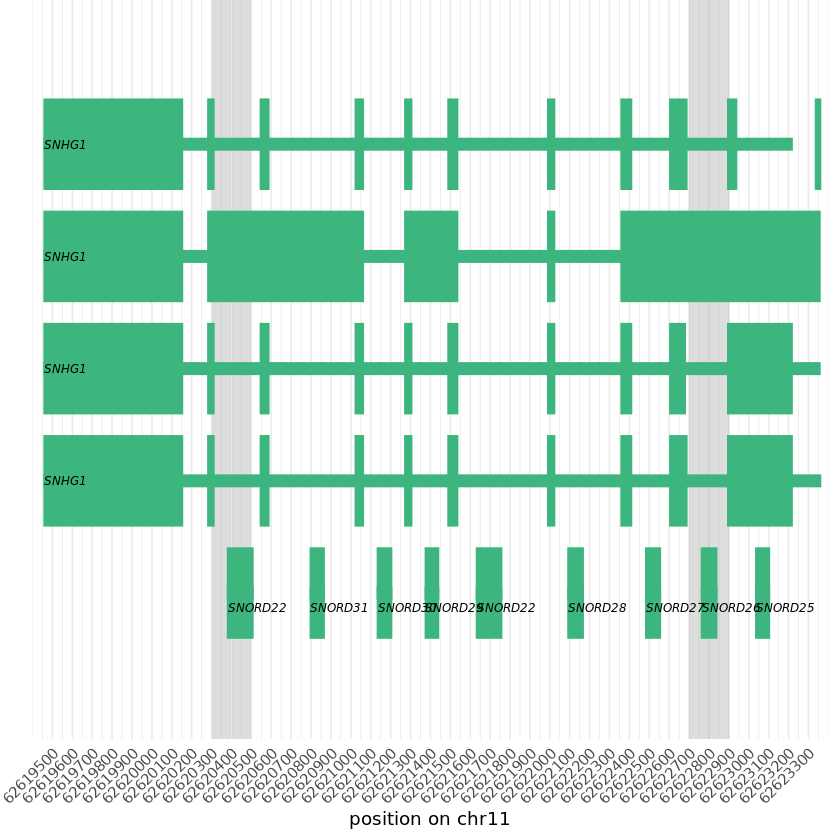

In [18]:
pTxSNHG1 = ggplot() + 
    geom_rect(data = deseqRes_signifSNHG1,mapping = aes(xmin=start, xmax=end,ymin=-Inf,ymax=Inf),
              fill="#AAAAAA", alpha=0.4) + 
    geom_rect(data = ucscAnnotTx, mapping=aes(xmin=txStart, xmax=txEnd,
                                  ymin=pos-0.05,ymax=pos+0.05),col="#3cb57e",fill="#3cb57e") + 
    geom_rect(data = ucscAnnotEx, mapping=aes(xmin=start, xmax=end,
                                  ymin=pos+0.4,ymax=pos-0.4),col="#3cb57e",fill="#3cb57e") + 
    # SNHG annotation within exons:
    geom_text(data = ucscAnnotTx[ ucscAnnotTx$symbol=="SNHG1",], hjust="left", size=2.5, 
              mapping=aes(x = txStart, y=pos, label=symbol), fontface=3) +
    # SNORD annotation below exons
    geom_text(data = ucscAnnotTx[ ucscAnnotTx$symbol!="SNHG1",], hjust="left", vjust=2.1, size=2.5, 
              mapping=aes(x = txStart, y=pos, label=symbol), fontface=3) +
     scale_y_continuous(breaks = 1:5, limits = c(-6,0)) + 
    #xlim(62619427, 62623380) + 
    scale_x_continuous(breaks = seq(62619500,62623300,100), limits = c(62619400,62623400),expand = c(0, 0)) + 
    xlab("position on chr11") + ylab("")+
    theme_minimal() + # theme_minimal()#theme_classic() theme_void
    theme(axis.text.x = element_text(angle = 45, vjust = 1.0, hjust=1),
         plot.margin=margin(-1,7,7,7), 
         panel.grid.major.y = element_blank(), panel.grid.minor.y = element_blank()) 
pTxSNHG1 

### plot

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”
Warning message in trans$transform(limits):
“NaNs produced”


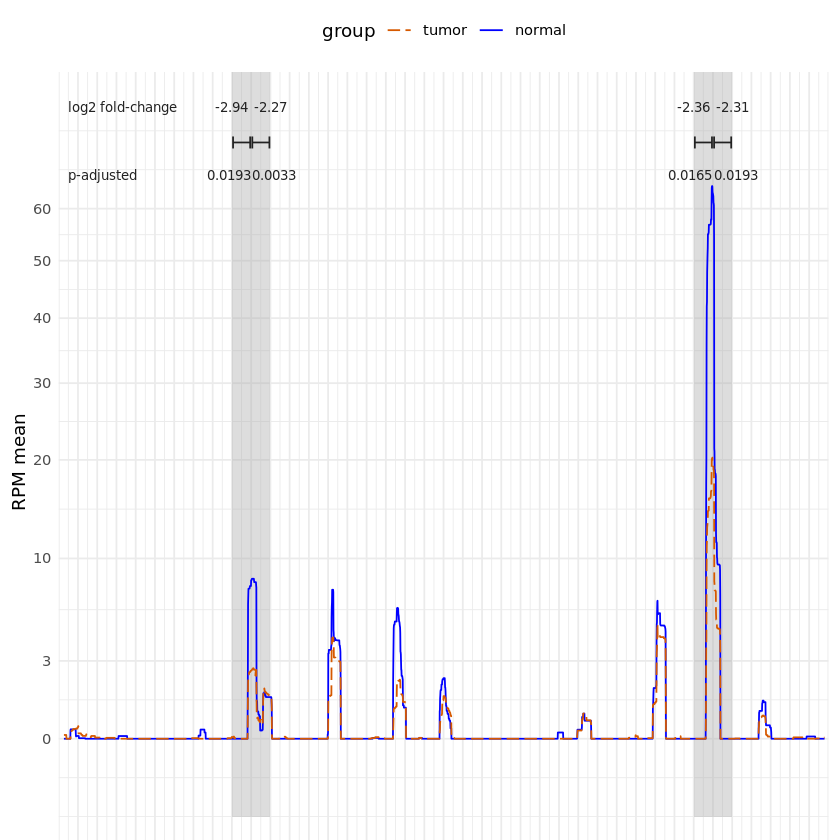

png 
  2

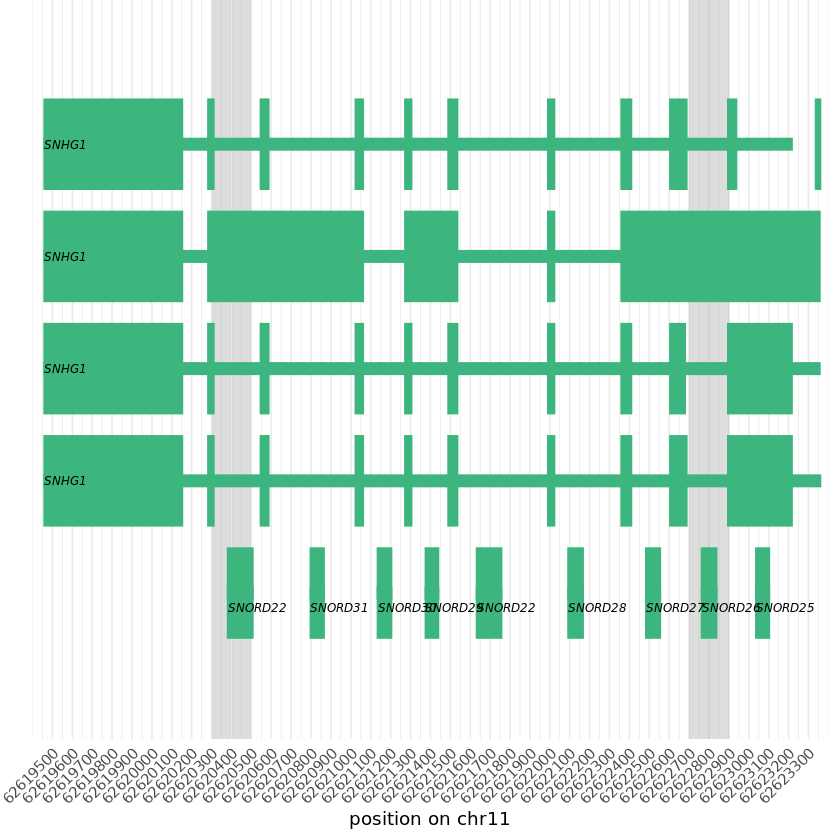

In [19]:
p1 = ggplot(data = allMeanSd) + 
    # grey filled rect around signif regions:
    geom_rect(data = deseqRes_signifSNHG1,mapping = aes(xmin=start, xmax=end,ymin=0,ymax=Inf),
              fill="#AAAAAA", alpha=0.4) +
    # mean expression:
    geom_line(aes(x = pos,y=mean_plus_1, linetype = group,col=group), alpha=1, size=0.5) + labs(y="RPM mean") + 
    # significant regions segments:
    geom_segment(data = deseqRes_signifSNHG1,mapping = aes(x = start+5,xend=end-5,y=75,yend=75), 
                 arrow=arrow(angle = 90, ends = "both",length = unit(0.05,"inches" )),color="#222222")+
    # signif regions p-adjusted and log2FC:
    annotate(geom="text", x=deseqRes_signifSNHG1$start[1]+50, y=68,hjust=.8, angle=0,
             label=round(deseqRes_signifSNHG1$padj[1],4), size=2.8,color="#222222") + 
    annotate(geom="text", x=deseqRes_signifSNHG1$start[2]+50, y=68,hjust=.2,angle=0,
             label=round(deseqRes_signifSNHG1$padj[2],4), size=2.8,color="#222222") + 
    annotate(geom="text", x=deseqRes_signifSNHG1$start[3]+50, y=68,hjust=.8,angle=0,
             label=round(deseqRes_signifSNHG1$padj[3],4), size=2.8,color="#222222") + 
    annotate(geom="text", x=deseqRes_signifSNHG1$start[4]+50, y=68,hjust=.2,angle=0,
             label=round(deseqRes_signifSNHG1$padj[4],4), size=2.8,color="#222222") + 
    annotate(geom="text", x=deseqRes_signifSNHG1$start[1]+50, y=83,hjust=.8,angle=0,
             label=round(deseqRes_signifSNHG1$log2FoldChange[1],2), size=2.8,color="#222222") + 
    annotate(geom="text", x=deseqRes_signifSNHG1$start[2]+50, y=83,hjust=0.2,angle=0,
             label=round(deseqRes_signifSNHG1$log2FoldChange[2],2), size=2.8,color="#222222") + 
    annotate(geom="text", x=deseqRes_signifSNHG1$start[3]+50, y=83,hjust=.8,angle=0,
             label=round(deseqRes_signifSNHG1$log2FoldChange[3],2), size=2.8,color="#222222") + 
    annotate(geom="text", x=deseqRes_signifSNHG1$start[4]+50, y=83,hjust=.2,angle=0,
             label=round(deseqRes_signifSNHG1$log2FoldChange[4],2), size=2.8,color="#222222") + 
    annotate(geom="text", x=62619450, y=83,label="log2 fold-change", size=2.8,color="#222222",hjust=0) + 
    annotate(geom="text", x=62619450, y=68,label="p-adjusted", size=2.8,color="#222222",hjust=0) + 

    scale_y_sqrt(breaks = c(1,4,11,21,31,41,51,61), labels=c(0,3,10,20,30,40,50,60), limits=c(-2,83)) + 
    scale_x_continuous(breaks = seq(62619400,62623400,100), limits = c(62619400,62623400)
                      ,expand = c(0, 0)) + 
    scale_linetype_manual(values = c("longdash","solid"),breaks=c("tumor","normal")) + 
    scale_color_manual(values=c("#d65900", "blue"), breaks=c("tumor","normal")) + 
    theme_minimal() + # theme_classic()#theme_classic() theme_void()
    theme(legend.position = "top", axis.text.x=element_blank(), axis.title.x=element_blank(),
         plot.margin=margin(4,7,-10,7))# ,

p1
pTxSNHG1 

png(filename = figureOutFile,width = 3600,height = 1800, res=380)
 gA <- ggplotGrob(p1)
 gB <- ggplotGrob(pTxSNHG1)
 maxWidth = grid::unit.pmax(gA$widths[2:5], gB$widths[2:5])
 gA$widths[2:5] <- as.list(maxWidth)
 gB$widths[2:5] <- as.list(maxWidth)
 grid.arrange(gA, gB, ncol=1,heights=c(5,2.8))

dev.off()